In [10]:
import polars as pl
import geopandas as gpd
from lonboard import Map, ScatterplotLayer
import matplotlib.pyplot as plt # New import for static maps
import contextily as cx # New import for contextily

# from lonboard.colormap import APPLE_COLORMAP # For potential coloring if needed later

In [2]:
# Load the datasets using Polars
try:
    mwi_df = pl.read_excel("mwi.xlsx")
    gis_df = pl.read_excel("gis.xlsx")
except Exception as e:
    print(f"Error loading CSV files: {e}")
    print("Please ensure 'mwi.csv' and 'gis.csv' are in the same directory as the notebook.")
    # You might want to exit or raise the exception here if loading fails
    raise

print("mwi.xlsx columns:", mwi_df.columns)
print("gis.xlsx columns:", gis_df.columns)

print("\nFirst 5 rows of mwi_df:")
print(mwi_df.head())

print("\nFirst 5 rows of gis_df:")
print(gis_df.head())

Could not determine dtype for column 13, falling back to string
Could not determine dtype for column 18, falling back to string
Could not determine dtype for column 36, falling back to string
Could not determine dtype for column 38, falling back to string
Could not determine dtype for column 79, falling back to string
Could not determine dtype for column 81, falling back to string
Could not determine dtype for column 91, falling back to string
Could not determine dtype for column 99, falling back to string
Could not determine dtype for column 138, falling back to string
Could not determine dtype for column 139, falling back to string
Could not determine dtype for column 141, falling back to string
Could not determine dtype for column 146, falling back to string
Could not determine dtype for column 147, falling back to string
Could not determine dtype for column 151, falling back to string


mwi.xlsx columns: ['m2682_meta_date_auto', 'm1855_meta_assessment_date', 'm1725_meta_interview_type', 'm0489_meta_survey_round', 'calc_adm2_local', 'm0303_meta_adm1_pcode', 'm0304_meta_adm2_pcode', 'm0305_meta_adm3_pcode', 'm0306_meta_adm4_pcode_other', 'm0306_meta_adm4_pcode', 'admin_4_name_txt_calc', 's1534_loc_loc_access', 'm0342_loc_site_type_multiple', 'm0342_loc_site_type_multiple_other', 'm1690_loc_depart_hh', 'm1541_loc_num_depart_hh_period', 'm1540_loc_num_depart_ind_period', 'm0349_loc_depart_period', 'm2990_loc_depart_internal', 'm2991_loc_depart_known', 'm1577_loc_main_dest_adm1', 'm1584_loc_main_depart_reason', 'm1584_loc_main_depart_reason_other', 'm1535_loc_arrival_time', 'm1537_loc_num_arrivals_hh', 'm1536_loc_num_arrival_ind_period', 'm2968_loc_num_men_idp', 'm2969_loc_num_women_idp', 'm2970_loc_num_children_idp', 'm0310_loc_num_idp_ind', 'm1727_loc_main_group_arrival_date', 'm2684_loc_arrivals_from_list', 'm2686_loc_arrivals_origin_adm1', 'm2685_loc_arrivals_origin_ad

In [12]:
# --- Data Preparation ---

# 1. Get unique assessed TA PCODEs from mwi.csv
assessed_pcodes_mwi = mwi_df.select(
    pl.col("m0305_meta_adm3_pcode").alias("TA_PCODE_MWI")
).unique().drop_nulls()
print(f"Number of unique TA PCODEs assessed in mwi.csv: {len(assessed_pcodes_mwi)}")

# 2. Prepare all TA geographic information from gis.csv
all_tas_gis = gis_df.select([
    pl.col("ADM3_CODE").alias("TA_PCODE_GIS"),
    pl.col("ADM3_NAME").alias("TA_Name"),
    pl.col("ADM2_NAME").alias("District_Name"),
    pl.col("ADM1_NAME").alias("Region_Name"),
    pl.col("Latitude"),
    pl.col("Longitude")
]).drop_nulls(subset=["TA_PCODE_GIS", "Latitude", "Longitude"])
print(f"Total TAs with geo-info in gis.csv: {len(all_tas_gis.unique(subset=['TA_PCODE_GIS']))}")


# 3. Create GeoDataFrame for ALL TAs from GIS data
all_tas_pd = all_tas_gis.to_pandas()
gdf_all_tas = gpd.GeoDataFrame(
    all_tas_pd,
    geometry=gpd.points_from_xy(all_tas_pd.Longitude, all_tas_pd.Latitude),
    crs="EPSG:4326"
)
# Ensure unique TAs if there are duplicates by PCODE in gis_df, keeping first
gdf_all_tas = gdf_all_tas.drop_duplicates(subset='TA_PCODE_GIS', keep='first')
print(f"Created GeoDataFrame gdf_all_tas with {len(gdf_all_tas)} unique TAs from GIS data.")


# 4. Create GeoDataFrame for ASSESSED TAs
#    Join assessed_pcodes_mwi with all_tas_gis to get full info for assessed TAs
assessed_tas_details_pl = assessed_pcodes_mwi.join(
    all_tas_gis, # Polars DataFrame with geo info
    left_on="TA_PCODE_MWI",
    right_on="TA_PCODE_GIS",
    how="inner" # Inner join to get only assessed TAs that have geo-info
).drop_nulls(subset=["Latitude", "Longitude", "TA_Name"])

if assessed_tas_details_pl.is_empty():
    print("No assessed Traditional Authorities found with corresponding geographic data. Check PCODEs.")
    gdf_assessed_tas = gpd.GeoDataFrame() # Empty GeoDataFrame
else:
    assessed_tas_pd_for_gdf = assessed_tas_details_pl.to_pandas()
    gdf_assessed_tas = gpd.GeoDataFrame(
        assessed_tas_pd_for_gdf,
        geometry=gpd.points_from_xy(assessed_tas_pd_for_gdf.Longitude, assessed_tas_pd_for_gdf.Latitude),
        crs="EPSG:4326"
    )
    print(f"Created GeoDataFrame gdf_assessed_tas with {len(gdf_assessed_tas)} assessed TAs.")


# 5. Identify NON-ASSESSED TAs
#    These are TAs in gdf_all_tas but not in gdf_assessed_tas (based on PCODE)
if not gdf_all_tas.empty and not gdf_assessed_tas.empty:
    assessed_pcodes_list = gdf_assessed_tas['TA_PCODE_MWI'].tolist() # Use the PCODE from mwi data
    gdf_non_assessed_tas = gdf_all_tas[~gdf_all_tas['TA_PCODE_GIS'].isin(assessed_pcodes_list)]
    print(f"Identified {len(gdf_non_assessed_tas)} non-assessed TAs with geo-info.")
elif not gdf_all_tas.empty and gdf_assessed_tas.empty:
    print("All TAs from GIS data are considered non-assessed as no assessed TAs were found/matched.")
    gdf_non_assessed_tas = gdf_all_tas.copy()
else:
    print("Cannot identify non-assessed TAs as gdf_all_tas is empty.")
    gdf_non_assessed_tas = gpd.GeoDataFrame() # Empty GeoDataFrame

Number of unique TA PCODEs assessed in mwi.csv: 78
Total TAs with geo-info in gis.csv: 433
Created GeoDataFrame gdf_all_tas with 433 unique TAs from GIS data.
Created GeoDataFrame gdf_assessed_tas with 78 assessed TAs.
Identified 355 non-assessed TAs with geo-info.


In [4]:
# --- Mapping with Lonboard ---

if not assessed_tas_with_geo.is_empty():
    # Convert Polars DataFrame to Pandas DataFrame for GeoPandas
    assessed_tas_pd = assessed_tas_with_geo.to_pandas()

    # Create a GeoDataFrame
    gdf_assessed_tas = gpd.GeoDataFrame(
        assessed_tas_pd,
        geometry=gpd.points_from_xy(assessed_tas_pd.Longitude, assessed_tas_pd.Latitude),
        crs="EPSG:4326"  # Assuming WGS84 coordinate system
    )

    # Create the ScatterplotLayer
    # You can customize color, radius, etc.
    ta_layer = ScatterplotLayer.from_geopandas(
        gdf_assessed_tas,
        get_fill_color=[255, 0, 0, 180],  # RGBA: Red, somewhat transparent
        get_radius=10000,  # Radius in meters (adjust based on map scale and density)
        pickable=True,    # Allows hovering to get tooltips
        auto_highlight=True
    )
    
    # Lonboard will automatically try to create tooltips from GeoDataFrame properties.
    # We have 'TA_Name', 'District_Name', 'Region_Name' which should appear.

    # Set initial view state for the map
    # Center the map around the mean latitude and longitude of the assessed TAs
    initial_view_state = {
        "longitude": gdf_assessed_tas.Longitude.mean(),
        "latitude": gdf_assessed_tas.Latitude.mean(),
        "zoom": 6,  # Adjust zoom level as needed
        "pitch": 0,
        "bearing": 0
    }

    # Create and display the map
    m = Map(layers=[ta_layer], view_state=initial_view_state)
    display(m)
else:
    print("Skipping map creation as no data is available.")

Map(custom_attribution='', layers=(ScatterplotLayer(auto_highlight=True, get_fill_color=[255, 0, 0, 180], get_…

Could not load naturalearth_lowres dataset for base map: The geopandas.dataset has been deprecated and was removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
Proceeding without a country boundary base map. Points will be plotted on an empty axis.


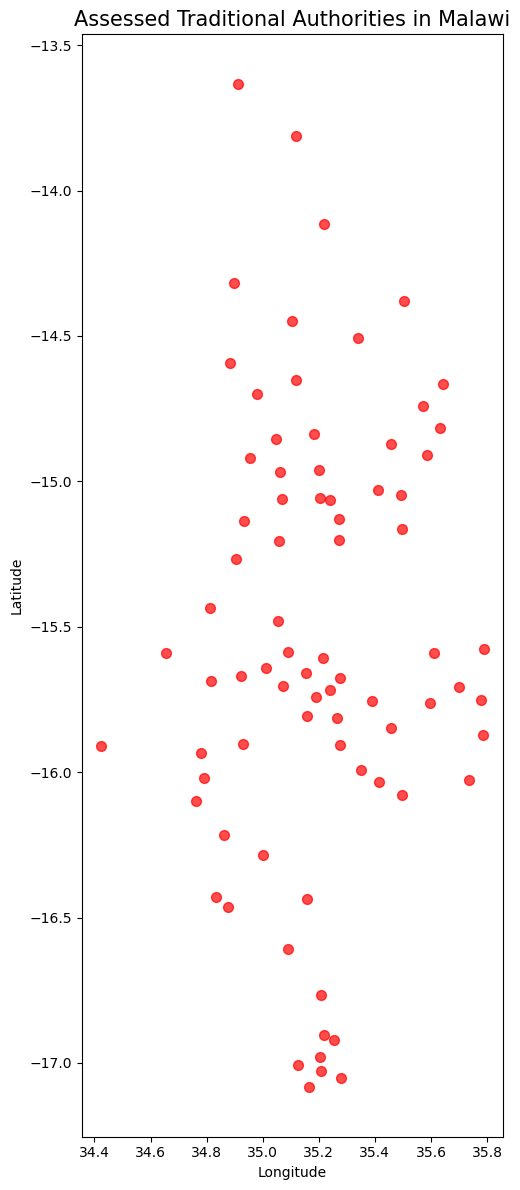

In [6]:
# --- Static Map with Geopandas and Matplotlib ---

if not assessed_tas_with_geo.is_empty() and 'gdf_assessed_tas' in locals():
    # 1. Load a base map for Malawi
    # You can use a shapefile of Malawi's boundaries if you have one.
    # For simplicity, we'll use the 'naturalearth_lowres' dataset included with geopandas
    # and filter for Malawi.
    try:
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        malawi_base_map = world[world.name == "Malawi"]
    except Exception as e:
        print(f"Could not load naturalearth_lowres dataset for base map: {e}")
        print("Proceeding without a country boundary base map. Points will be plotted on an empty axis.")
        malawi_base_map = None # Set to None so we can handle its absence

    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 12)) # Adjust figsize as needed

    # 2. Plot the base map (if available)
    if malawi_base_map is not None and not malawi_base_map.empty:
        malawi_base_map.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.7)
    elif malawi_base_map is not None and malawi_base_map.empty:
        print("Warning: Malawi not found in naturalearth_lowres dataset. Plotting points without country boundary.")

    # 3. Plot the assessed Traditional Authorities (points)
    gdf_assessed_tas.plot(
        ax=ax,
        marker='o',
        color='red',
        markersize=50,  # Adjust marker size
        alpha=0.7,
        label='Assessed TAs'
    )

    # 4. Add titles and labels
    ax.set_title('Assessed Traditional Authorities in Malawi', fontsize=15)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Optionally, add a legend if you have multiple layers or categories
    # ax.legend()

    # Improve layout
    plt.tight_layout()
    plt.show()
else:
    print("Skipping static map creation as no data ('gdf_assessed_tas') is available or was created.")

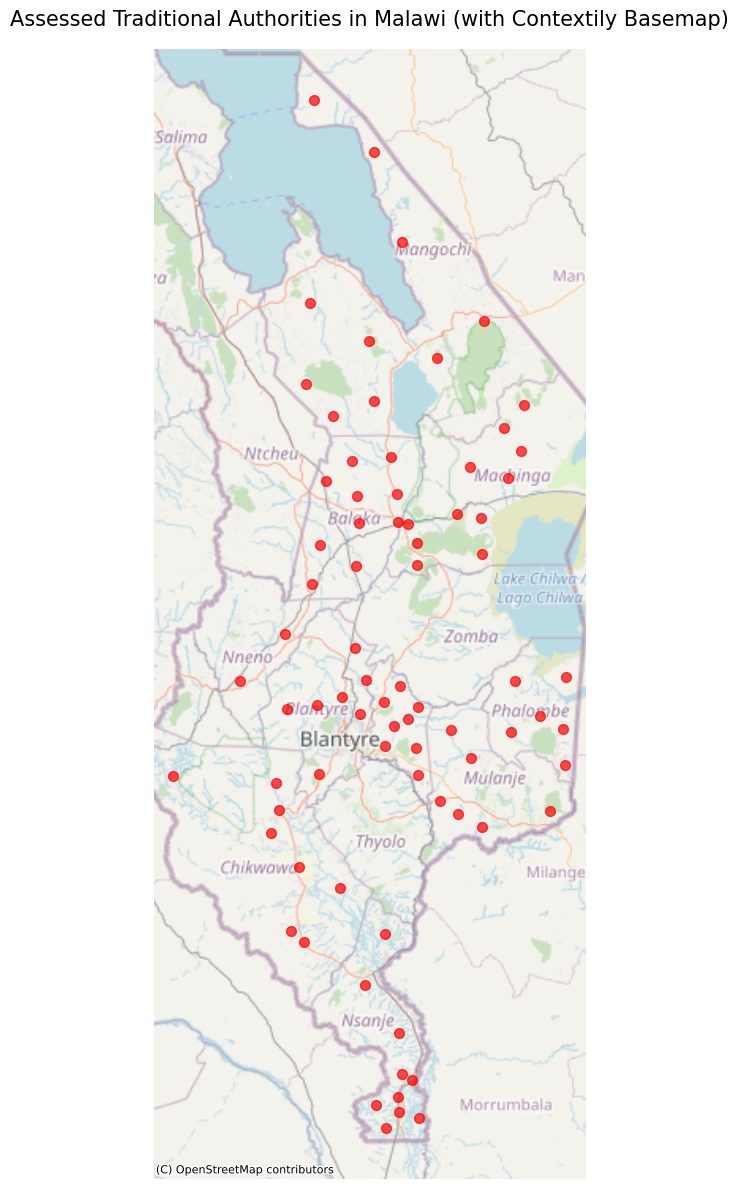

In [11]:
# --- Static Map with Geopandas, Matplotlib, and Contextily ---

if not assessed_tas_with_geo.is_empty() and 'gdf_assessed_tas' in locals() and not gdf_assessed_tas.empty:
    # 1. Ensure the GeoDataFrame is in Web Mercator projection (EPSG:3857) for contextily
    #    Contextily works best with data in this projection.
    gdf_assessed_tas_wm = gdf_assessed_tas.to_crs(epsg=3857)

    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 12)) # Adjust figsize as needed

    # 2. Plot the assessed Traditional Authorities (points)
    #    We plot the data first so contextily can determine the extent.
    gdf_assessed_tas_wm.plot(
        ax=ax,
        marker='o',
        color='red',
        markersize=50,    # Adjust marker size
        alpha=0.7,
        label='Assessed TAs',
        zorder=2          # Ensure points are plotted on top of the basemap
    )

    # 3. Add the basemap using contextily
    #    You can choose different providers and map styles.
    #    Common providers: cx.providers.OpenStreetMap.Mapnik, cx.providers.Stamen.TonerLite,
    #                      cx.providers.Stamen.Terrain, cx.providers.CartoDB.Positron
    try:
        cx.add_basemap(
            ax,
            crs=gdf_assessed_tas_wm.crs.to_string(), # Use the CRS of your plotted data
            source=cx.providers.OpenStreetMap.Mapnik, # Or another provider
            zoom='auto', # 'auto' tries to find a good zoom level, or set an integer
            alpha=0.8,   # Basemap transparency
            zorder=1     # Ensure basemap is below the points
        )
    except Exception as e:
        print(f"Error adding basemap with contextily: {e}")
        print("This might be due to network issues or provider changes.")
        print("The points will be plotted without a web basemap.")


    # 4. Add titles and labels (optional, as basemap often has labels)
    ax.set_title('Assessed Traditional Authorities in Malawi (with Contextily Basemap)', fontsize=15)
    ax.set_axis_off() # Often good to turn off axis for tile maps

    # Optionally, add a legend
    # handles, labels = ax.get_legend_handles_labels()
    # if handles: # Only add legend if there are labeled items
    #     ax.legend(handles, labels, loc='upper right')

    # Improve layout
    plt.tight_layout()
    plt.show()
else:
    print("Skipping static map creation as no data ('gdf_assessed_tas') is available or was created/empty.")

Plotting 355 non-assessed TAs.
Plotting 78 assessed TAs.


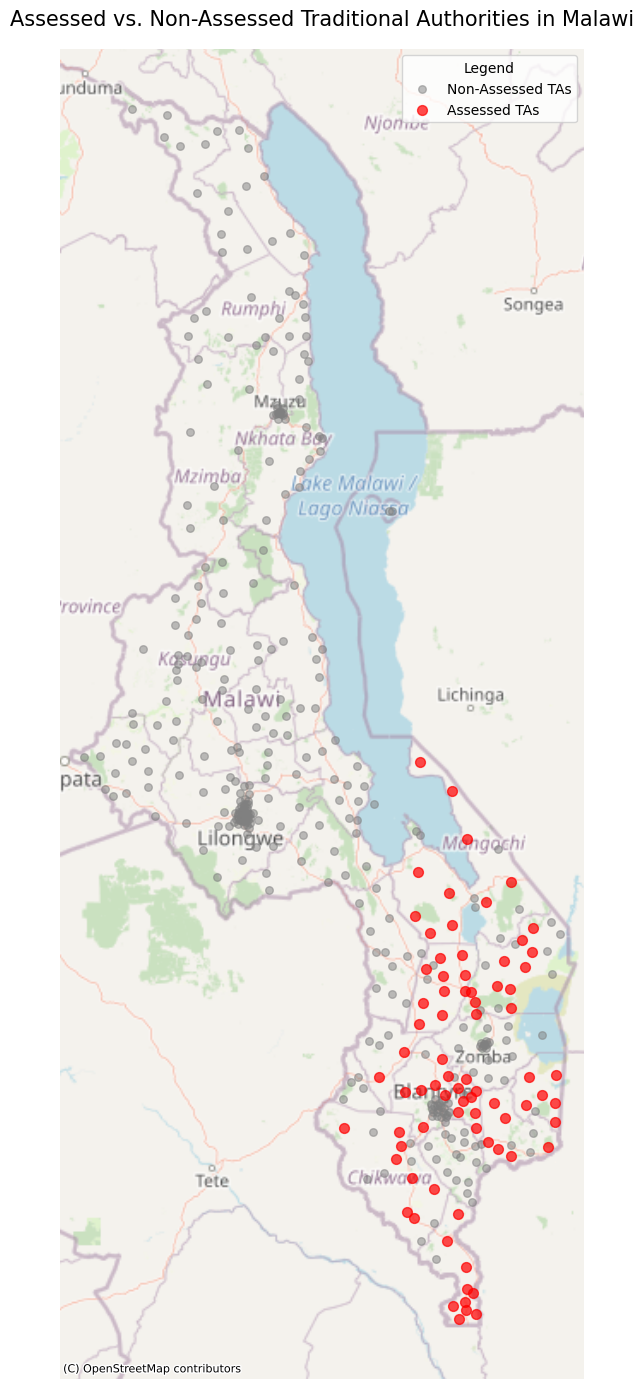

In [13]:
# --- Static Map with Geopandas, Matplotlib, and Contextily ---

# Check if we have any TAs to plot at all
if (('gdf_assessed_tas' in locals() and not gdf_assessed_tas.empty) or \
    ('gdf_non_assessed_tas' in locals() and not gdf_non_assessed_tas.empty)):

    fig, ax = plt.subplots(1, 1, figsize=(12, 14)) # Adjust figsize as needed

    # 1. Plot NON-ASSESSED TAs (if any) - in Web Mercator
    if 'gdf_non_assessed_tas' in locals() and not gdf_non_assessed_tas.empty:
        gdf_non_assessed_tas_wm = gdf_non_assessed_tas.to_crs(epsg=3857)
        gdf_non_assessed_tas_wm.plot(
            ax=ax,
            marker='o',
            color='gray',
            markersize=30,  # Slightly smaller or different style
            alpha=0.5,
            label='Non-Assessed TAs',
            zorder=2 # Above basemap, potentially below assessed
        )
        print(f"Plotting {len(gdf_non_assessed_tas_wm)} non-assessed TAs.")


    # 2. Plot ASSESSED TAs (if any) - in Web Mercator
    #    Plotted after non-assessed to ensure they are on top if they overlap.
    if 'gdf_assessed_tas' in locals() and not gdf_assessed_tas.empty:
        gdf_assessed_tas_wm = gdf_assessed_tas.to_crs(epsg=3857)
        gdf_assessed_tas_wm.plot(
            ax=ax,
            marker='o',
            color='red',
            markersize=50,
            alpha=0.7,
            label='Assessed TAs',
            zorder=3 # Higher zorder to be on top
        )
        print(f"Plotting {len(gdf_assessed_tas_wm)} assessed TAs.")


    # 3. Add the basemap using contextily
    #    Contextily needs the CRS of the data already plotted on the axis.
    #    If both assessed and non-assessed were plotted, their CRS (gdf_assessed_tas_wm.crs) is the same.
    #    If only one type was plotted, use its CRS. If neither, this block won't run.
    current_crs_for_basemap = None
    if 'gdf_assessed_tas_wm' in locals() and not gdf_assessed_tas_wm.empty:
        current_crs_for_basemap = gdf_assessed_tas_wm.crs.to_string()
    elif 'gdf_non_assessed_tas_wm' in locals() and not gdf_non_assessed_tas_wm.empty:
        current_crs_for_basemap = gdf_non_assessed_tas_wm.crs.to_string()

    if current_crs_for_basemap:
        try:
            cx.add_basemap(
                ax,
                crs=current_crs_for_basemap,
                source=cx.providers.OpenStreetMap.Mapnik, # Or another provider
                zoom='auto',
                alpha=0.8,
                zorder=1 # Basemap below all data points
            )
        except Exception as e:
            print(f"Error adding basemap with contextily: {e}")
            print("The points will be plotted without a web basemap.")
    else:
        print("No data plotted, so skipping basemap.")

    # 4. Add titles and labels
    ax.set_title('Assessed vs. Non-Assessed Traditional Authorities in Malawi', fontsize=15)
    ax.set_axis_off()

    # 5. Add a legend
    handles, labels = ax.get_legend_handles_labels()
    if handles: # Only add legend if there are labeled items
        ax.legend(handles, labels, loc='best', title="Legend")


    plt.tight_layout()
    plt.show()
else:
    print("Skipping static map creation as no TA data (assessed or non-assessed) is available or was created/empty.")